In [2]:
from camelyonpatch import CamelyOnPatch
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES']=''


# Real world Bio-Medical Datasets

This notebook is a start on how you can use machine learning on bio-medical datasets.

## Tumor Identification Segmentation

We're going to start with the PatchCamelyon (PCam)
https://github.com/basveeling/pcam

<img src=https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg>


## The RAW Data

This dataset was created from whole slide images for example this one:
* Whole slide image scans are gigantic!
    * Really Big
* Below is a low resolution view
* These image don't generally fit into memory, but python packages exist to Manipulate them

For this file we're relying on a package called openslide


In [ ]:
import openslide


 Labels in this dataset are the boundaries of each tumor ( or no boundaries if the tissue is healthy)
 
 
 

In [4]:
cpd=CamelyOnPatch('/home/jsearcy/Desktop/ML Data Sets/pcamv1')
#This is super slow take a look at this
image,new_image,mask=cpd.scan_tiff()

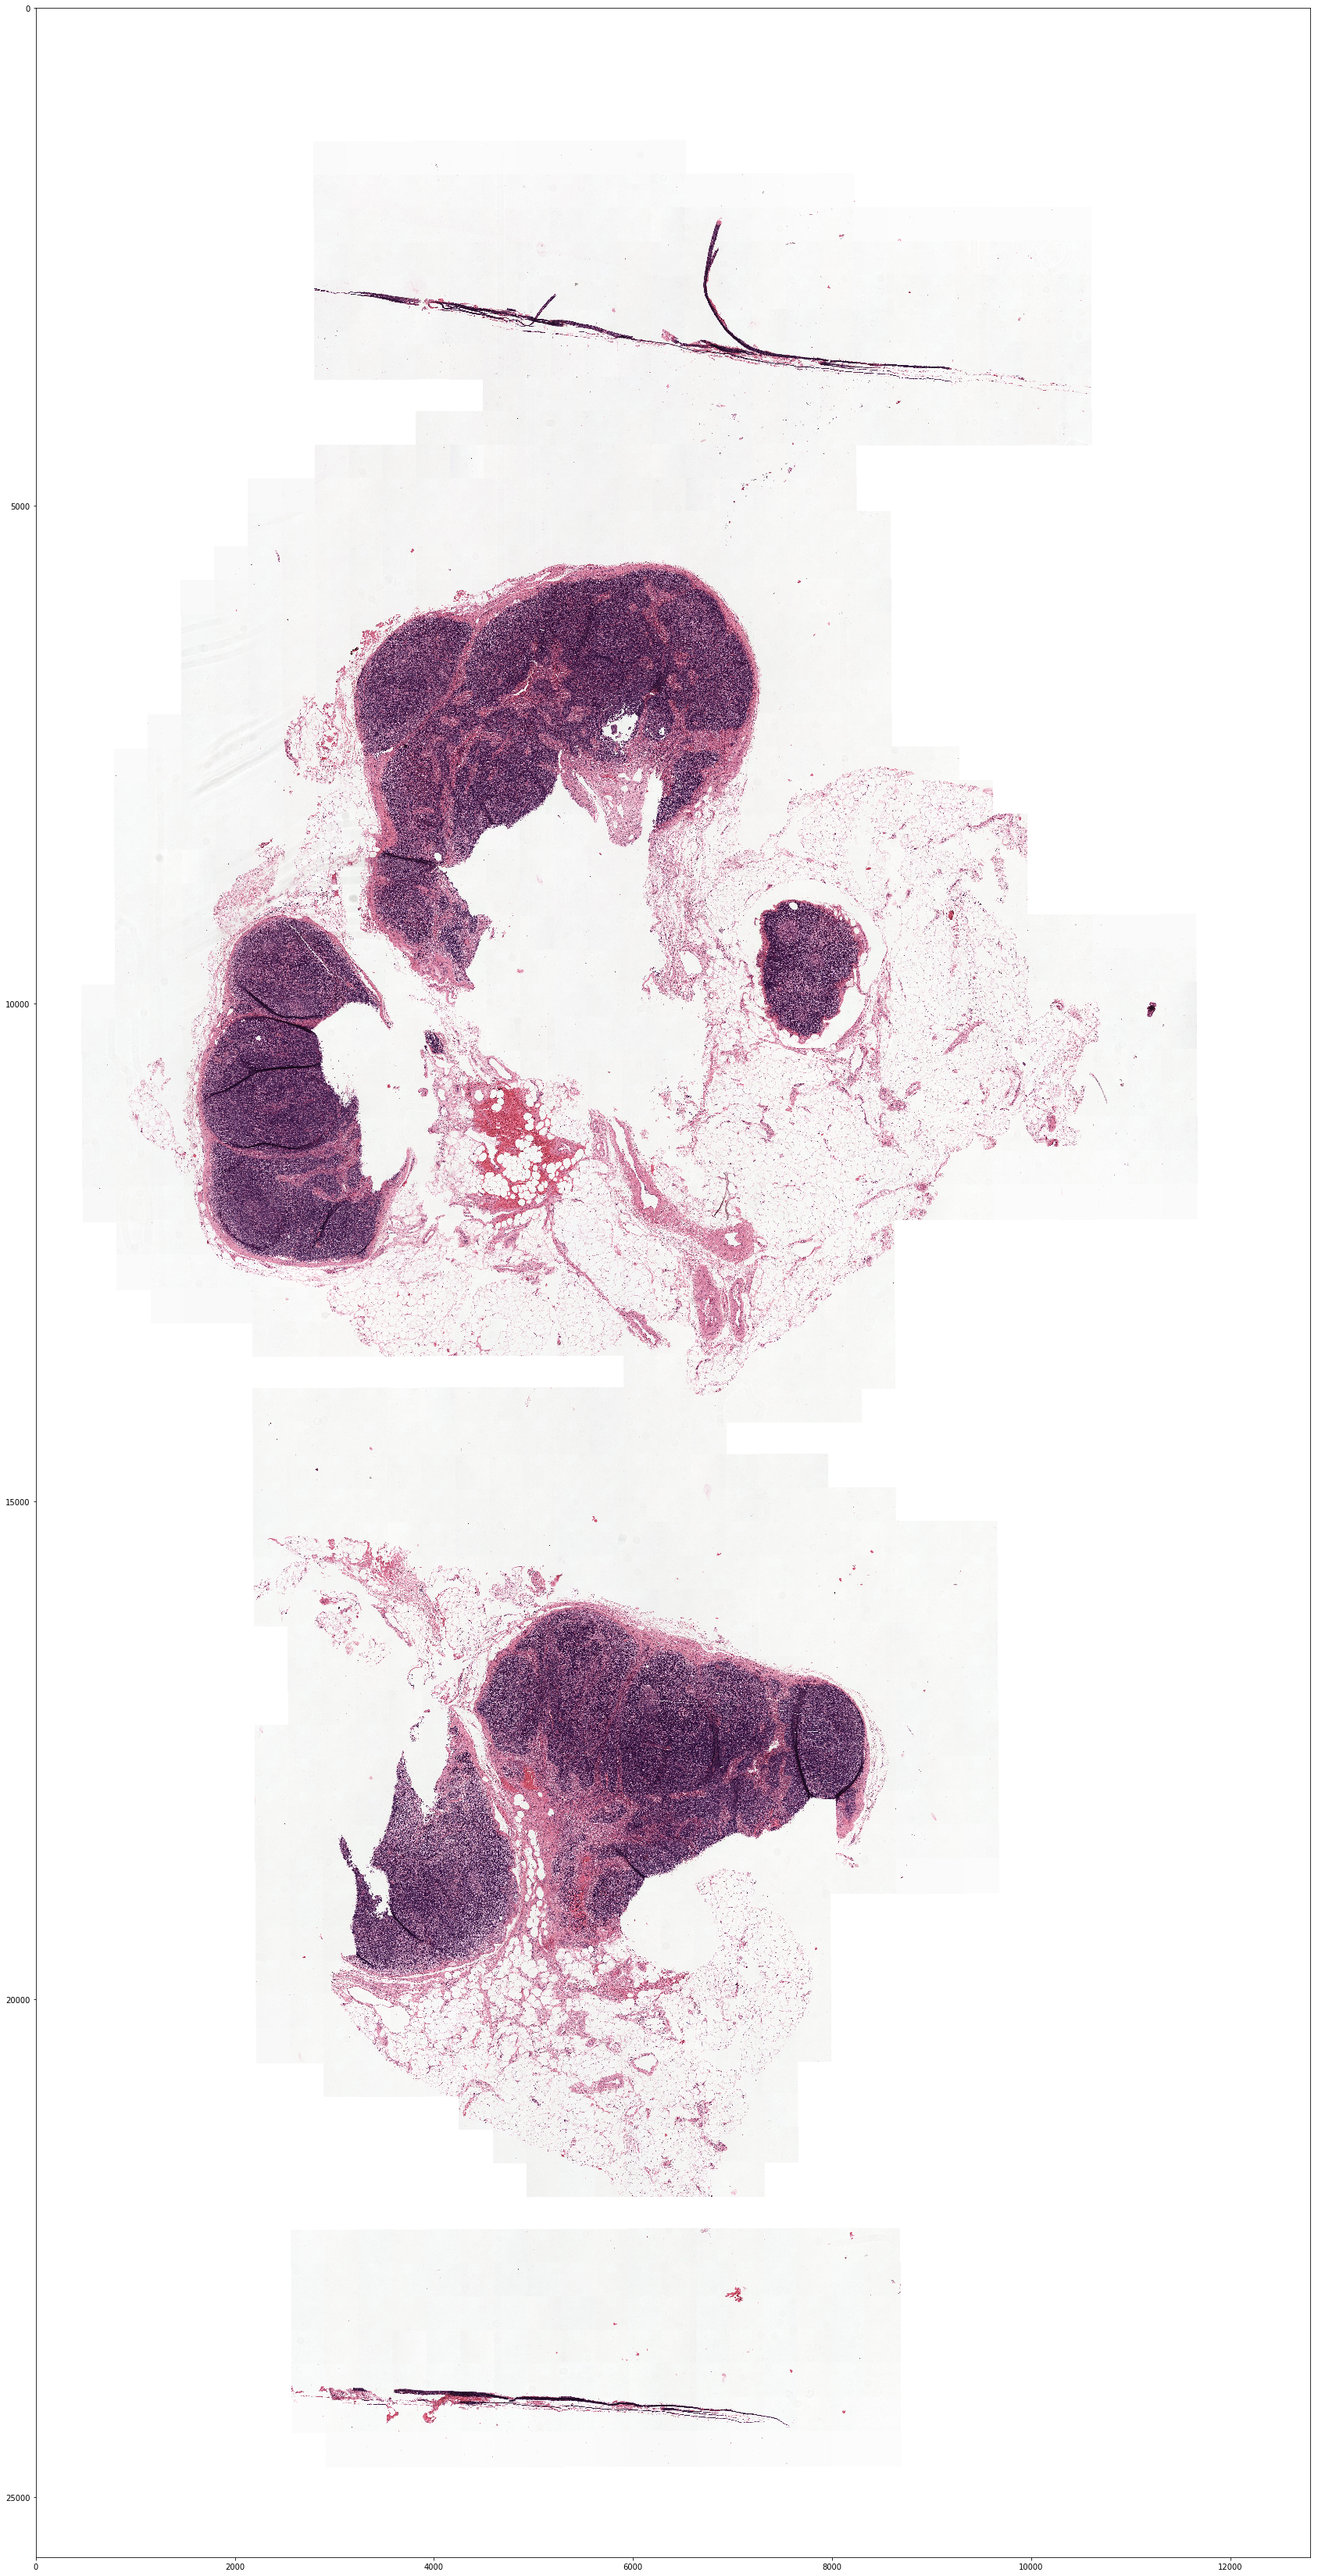

In [8]:
f=plt.figure(figsize=(30,60))
plt.imshow(image)
plt.show()

This image is full Resolution is too large to fit in memory, but it dosen't mean we can't still use what we've learned to start analyzing it

# Splitting the Dataset

Instead of looking at the whole image we can look at one small piece say 96x96 pixels worth. 
* Ask are any of the pixels in the middle 32x32 cancerous
    * If yes label it with a 1
    * If no label it with a zero
    * Why only the middle 32x32 pixels
        * Allows network to have some context to under-standing the center pixels
        * Otherwise one pixel in the top corner being cancerous would label the whole image cancerous
* This turns one picture into 1000's of trainning examples

* Important Detail about the data split
    * Having a lot of training examples is great
        * But what we really want to know is can we use this algorithm to identify tumors it hasn't seen before
        * The dataset used above splits the data by randomly assign each tumor to a dataset rather than randomly assigning each image to a dataset
            * Make's sure the model gernalizes to new tumors and not just those seen in the training set





[[[0.88627451 0.81960784 0.88235294]
  [0.87843137 0.82352941 0.88235294]
  [0.8745098  0.82745098 0.8745098 ]
  ...
  [0.85490196 0.69803922 0.90196078]
  [0.83921569 0.71372549 0.86666667]
  [0.7372549  0.63137255 0.75294118]]

 [[0.8745098  0.81960784 0.87843137]
  [0.87058824 0.82352941 0.87843137]
  [0.86666667 0.82745098 0.87058824]
  ...
  [0.49803922 0.34117647 0.58823529]
  [0.62352941 0.49411765 0.70980392]
  [0.8        0.69019608 0.88235294]]

 [[0.87058824 0.82352941 0.87843137]
  [0.86666667 0.82352941 0.87843137]
  [0.85882353 0.82745098 0.87058824]
  ...
  [0.30196078 0.14901961 0.45882353]
  [0.16470588 0.03137255 0.32941176]
  [0.5372549  0.41960784 0.70196078]]

 ...

 [[0.48235294 0.31764706 0.64705882]
  [0.50196078 0.35294118 0.67843137]
  [0.49411765 0.35686275 0.67843137]
  ...
  [0.79607843 0.52941176 0.82352941]
  [0.88627451 0.60784314 0.8745098 ]
  [0.79215686 0.50980392 0.76078431]]

 [[0.35294118 0.20392157 0.54509804]
  [0.35294118 0.21960784 0.55686275]


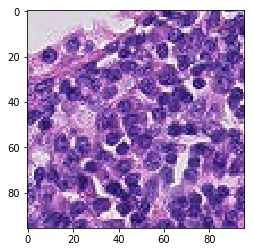

In [10]:
cpd=CamelyOnPatch('/home/jsearcy/Desktop/ML Data Sets/pcamv1')
print(cpd.x_train[0])
plt.imshow(cpd.x_train[0])


# Try a model to use this dataset

## More Tips and Tricks

# Whole Image Scan
* Using our Model
* Class Balance
* Thresholds


In [ ]:
def add_target_area(x):
    batch=tf.shape(x)[0]
    
    target_area=np.zeros((1,96,96,3),dtype='float32')
    target_area[0,32:64,32:64,:]=1
    tf_area=tf.constant(target_area)
    tf_area=tf.tile(tf_area,[batch,1,1,1])
    output=tf.concat([x,tf_area],axis=-1)
    return output


print(dir(tf.keras.applications))
image_input=tf.keras.layers.Input(shape=(96,96,3))
cnn=tf.keras.layers.Lambda(add_target_area)(image_input)

small_feature=tf.keras.layers.Conv2D(64,10,padding='same')(cnn)
small_output=tf.keras.layers.GlobalAveragePooling2D()(small_feature)


cnn1=tf.keras.layers.Conv2D(64,4,padding='same')(cnn)
cnn=tf.keras.layers.LeakyReLU()(cnn1)

cnn=tf.keras.layers.Conv2D(64,4,padding='same')(cnn)
cnn=tf.keras.layers.LeakyReLU()(cnn)
cnn=tf.keras.layers.Conv2D(64,4,padding='same')(cnn)
cnn=tf.keras.layers.LeakyReLU()(cnn)
cnn=tf.keras.layers.Add()([cnn,cnn1])
cnn=tf.keras.layers.Dropout(.3)(cnn)

cnn2=tf.keras.layers.Conv2D(128,4,2,padding='same')(cnn1)
cnn=tf.keras.layers.LeakyReLU()(cnn2)

cnn=tf.keras.layers.Conv2D(128,4,padding='same')(cnn)
cnn=tf.keras.layers.LeakyReLU()(cnn)
cnn=tf.keras.layers.Conv2D(128,4,padding='same')(cnn)
cnn=tf.keras.layers.LeakyReLU()(cnn)
cnn=tf.keras.layers.Add()([cnn,cnn2])
cnn=tf.keras.layers.Dropout(.3)(cnn)



cnn=tf.keras.layers.GlobalAveragePooling2D()(cnn)
cnn=tf.keras.layers.Concatenate()([cnn,small_output])
cnn=tf.keras.layers.Dropout(.5)(cnn)
cnn=tf.keras.layers.Dense(100)(cnn)
cnn=tf.keras.layers.Dropout(.5)(cnn)
cnn=tf.keras.layers.Dense(1,activation='sigmoid')(cnn)


model=tf.keras.models.Model(image_input,cnn)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()



#pretrained_model=tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=(96,96,3))





In [ ]:
print(np.max(cpd.x_develop))

In [ ]:
batch_size=100
es=tf.keras.callbacks.EarlyStopping(patience=10)

model.fit_generator( 
                    cpd.datagen.flow(cpd.x_train,np.squeeze(cpd.y_train),batch_size=batch_size ),
                    steps_per_epoch=300,
                    validation_data=(cpd.x_develop,np.squeeze(cpd.y_develop)),                    
                    epochs=100,callbacks=[es])


In [ ]:
import matplotlib.pyplot as plt

y_pred_train=np.squeeze(model.predict(cpd.x_train[0:10000]))
plt.hist([v for v,p in zip(y_pred_train,np.squeeze(cpd.y_train[0:10000])) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_train,np.squeeze(cpd.y_train[0:10000])) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()



y_pred_test=np.squeeze(model.predict(cpd.x_test))
plt.hist([v for v,p in zip(y_pred_test,np.squeeze(cpd.y_test)) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_test,np.squeeze(cpd.y_test)) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()

y_pred_develop=np.squeeze(model.predict(cpd.x_develop))
plt.hist([v for v,p in zip(y_pred_develop,np.squeeze(cpd.y_develop)) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_develop,np.squeeze(cpd.y_develop)) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()


In [ ]:
import openslide
import matplotlib.pyplot as plt
from zipfile import ZipFile
import xml.etree.ElementTree as ET

#tiff_file='/home/jsearcy/Desktop/ML Data Sets/pcamv1/tumor_001.tif'
tiff_file='/home/jsearcy/Desktop/ML Data Sets/pcamv1/normal_001.tif'

root = ET.fromstring(ZipFile("/home/jsearcy/Desktop/ML Data Sets/lesion_annotations_train.zip").open('tumor_001.xml').read())
 




slide_image=openslide.OpenSlide(tiff_file)
coords=slide_image.level_dimensions[0]
res=slide_image.level_dimensions[2]


In [ ]:
len(root.getchildren())
tumor_coords=[(float(i.attrib['X']),float(i.attrib['Y'])) for i in root.iter() if i.tag=="Coordinate"]

In [ ]:
x_offset=35000
y_offset=100000
image=np.asarray(slide_image.read_region( (x_offset,y_offset),2,(800*16,800*16)  ))


    



In [ ]:
new_tumor=[]
for x,y in tumor_coords:
    new_x=(x-x_offset)/4.
    new_y=(y-y_offset)/4.
    new_tumor.append((new_x,new_y))
    
new_tumor_small=[]
for x,y in tumor_coords:
    new_x=(x-x_offset)/(4.*32.)
    new_y=(y-y_offset)/(4.*32.)
    new_tumor_small.append((new_x,new_y))
    
    

In [ ]:
new_x,new_y

In [ ]:
%matplotlib qt
f=plt.figure(figsize=(20,40))
plt.imshow(image)
plt.scatter(*zip(*new_tumor))

In [ ]:
res_x,res_y,chann=image.shape
new_image=np.zeros((res_x//32,res_y//32,3))
mask=np.zeros((res_x//32,res_y//32))
        
for x in range(0,res_x-96,32):
    pred_data=[]
    for y in range(0,res_y-96,32):
        data=image[x:x+96,y:y+96,:]
        pred_data.append(np.expand_dims(data[:,:,0:3],0)/255.)                
        color=np.mean(np.mean(data[32:64,32:64,:],axis=0),axis=0)
#                print(color)
#                print(x//32,y//32)
        new_image[x//32,y//32,:]=color[0:3]
    output=model.predict(np.concatenate(pred_data,axis=0))
    mask[x//32,0:len(output)]= np.squeeze(output)
                



In [ ]:
coords,coords[0]*coords[1]

In [ ]:
#f=plt.figure(figsize=(10,20))

#plt.imshow(new_image/255.)
#plt.scatter(*zip(*new_tumor_small))
#plt.show()

f=plt.figure(figsize=(10,20))
plt.imshow(mask>0.997,cmap='Reds')
plt.scatter(*zip(*new_tumor_small),s=.2)

plt.show()


In [ ]:
(image[:,:,3]==255).all()


In [ ]:
image=tf.keras.layers.Lambda(lambda x: tf.image.resize_image_with_crop_or_pad(
    x*255,
    96,
    96
))(image_input)


In [ ]:
pretrained_model=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(96,96,3),input_tensor=image)

pretrained_output=pretrained_model.output
pretrained_input=pretrained_model.input

for layer in pretrained_model.layers:
    layer.trainable=False


In [ ]:
#flatten=tf.keras.layers.GlobalMaxPooling2D()(pretrained_output)
flatten=tf.keras.layers.Flatten()(pretrained_output)
top=tf.keras.layers.Dropout(0.9)(flatten)
top=tf.keras.layers.Dense(500)(top)
top=tf.keras.layers.LeakyReLU()(top)
top=tf.keras.layers.Dropout(0.6)(top)

top=tf.keras.layers.Dense(500)(top)
top=tf.keras.layers.LeakyReLU()(top)
top=tf.keras.layers.Dropout(0.6)(top)

last_layer=tf.keras.layers.Dense(1,activation='sigmoid')(top)
res_model=tf.keras.models.Model(pretrained_input,last_layer)

res_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

res_model.summary()


In [ ]:
batch_size=100
es=tf.keras.callbacks.EarlyStopping(patience=3)

res_model.fit_generator( 
                    cpd.datagen.flow(cpd.x_train,np.squeeze(cpd.y_train),batch_size=batch_size ),
                    steps_per_epoch=300,
                    validation_data=(cpd.x_develop,np.squeeze(cpd.y_develop)),                    
                    epochs=100,
                    callbacks=[es])

In [ ]:
import matplotlib.pyplot as plt

y_pred_train=np.squeeze(res_model.predict(cpd.x_train[0:10000]))
plt.hist([v for v,p in zip(y_pred_train,np.squeeze(cpd.y_train[0:10000])) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_train,np.squeeze(cpd.y_train[0:10000])) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()



y_pred_test=np.squeeze(res_model.predict(cpd.x_test))
plt.hist([v for v,p in zip(y_pred_test,np.squeeze(cpd.y_test)) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_test,np.squeeze(cpd.y_test)) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()

y_pred_develop=np.squeeze(res_model.predict(cpd.x_develop))
plt.hist([v for v,p in zip(y_pred_develop,np.squeeze(cpd.y_develop)) if p ],range=(0,1),bins=50,density=True,histtype='step')
plt.hist([v for v,p in zip(y_pred_develop,np.squeeze(cpd.y_develop)) if not p ],range=(0,1),bins=50,density=True,histtype='step')
plt.show()

In [ ]:
postive=[v for v in np.argsort(y_pred_develop) if cpd.y_develop[v]]
negative=[v for v in np.argsort(y_pred_develop) if not cpd.y_develop[v]]

f=plt.figure(figsize=(20,2))
plt.imshow(np.hstack(cpd.x_develop[postive[0:10]]))
plt.show()
f=plt.figure(figsize=(20,2))

plt.imshow(np.hstack(cpd.x_develop[negative[10:20]]))
plt.show()
f=plt.figure(figsize=(20,2))

plt.imshow(np.hstack(cpd.x_develop[postive[20:30]]))

f=plt.figure(figsize=(10,10))
plt.imshow(cpd.x_develop[postive[20]] )
print(y_pred_develop[postive[9]])
plt.show()






In [ ]:
#model.fit(cpd.x_train,np.squeeze(cpd.y_train),
#          validation_data=(cpd.x_develop,np.squeeze(cpd.y_develop)),                    
#          epochs=10,shuffle='batch')

In [ ]:
sort=np.argsort(y_pred)
#print(cpd.y_test[sort[0:20]])
index=8
print(cpd.y_test[sort[index]],y_pred[sort[index]])
plt.imshow(cpd.x_test[sort[index]])







In [ ]:
sess=tf.keras.backend.get_session()
im_out=sess.run(image,feed_dict={image_input:cpd.x_test[0:10]})

plt.imshow(cpd.x_test[3])
plt.show()
print(np.min(im_out),np.max(im_out))
plt.imshow(im_out[3].astype('uint8'))

plt.show()


In [ ]:
import matplotlib.pyplot as plt
f=plt.figure(figsize=(30,5))
plt.imshow(np.hstack(cpd.x_test[0:10]))
plt.show()
f=plt.figure(figsize=(30,5))

plt.imshow(np.hstack(cpd.x_train[0:10]))
plt.show()
f=plt.figure(figsize=(30,5))

plt.imshow(np.hstack(cpd.x_develop[0:10]))

plt.show()

In [ ]:
cpd.x_test[1]/255.
